In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import autograd.numpy as np
import pylab as plt
import seaborn as snb

from scipy.optimize import minimize
from autograd import value_and_grad

from exercise4 import plot_with_uncertainty
from exercise4 import generate_samples
from exercise4 import add_colorbar

snb.set_style('darkgrid')
snb.set(font_scale=1.5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 02477 Bayesian Machine Learning: Gaussian processes

The purpose of this exercise is to
- become familiar with the squared exponential (i.e., exponentiated quadratic) kernel and understand its parameters
- become familiar with Gaussian processes and learn to use them as prior distribution for unknown latent functions
- use Gaussian processes for regression

The exercise is divided into four parts:
- Part 1: The squared exponential kernel
- Part 2: Gaussian process regression on toy data set
- Part 3: Hyperparameter optimization using the marginal likelihood
- Part 4: Modeling the bike sharing dataset

### Part 1: Priors on functions and the squared exponential kernel

When we worked with parametric models such as linear regression and logistic regression, we assigned prior distributions on the weights $\mathbf{w}$ of the models. In contrast, we can think of Gaussian processes as prior distributions directly on the function space

\begin{align*}
y(\mathbf{x}) \sim \mathcal{GP}\left(0 \, , \, k\left(\mathbf{x}, \mathbf{x}'\right)\right). \tag{1}
\end{align*}

The Gaussian process is completely specified by its mean and covariance function. Most often we take the mean function to be zero because we don't have any prior information on the mean function. 

The **covariance function** (or kernel function) $k(\mathbf{x}, \mathbf{x}')$ thus completely determines the a priori behaviour of the latent function $y$. Specically, the covariance function determines the covariance of the latent function $y$ when evaluated at two different inputs, i.e.

$$\begin{align*}
\text{cov}[y(\mathbf{x}), y(\mathbf{x}')] = k(\mathbf{x}, \mathbf{x}'). \tag{2}
\end{align*}$$


The **squared exponential** covariance function is given by

\begin{align*} 
    k(\mathbf{x}_n, \mathbf{x}_m) = \kappa^2 \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_m\|^2_ 2}{2\ell^2}\right), \tag{3}
\end{align*}

where $\kappa > 0$ and $\ell > 0$ are hyperparameters of the kernel. This specific covariance function is perhaps the most common covariance function used in statistics and machine learning. It is also known as the radial basis function kernel, the gaussian kernel, or the exponentiated quadratic kernel. 

The purpose of the first part is to become familiar with this covariance function and understand its properties. We will do this by generating and visualizing samples from a Gaussian process with the squared exponential kernel. 

Below you are given a vector $\mathbf{X}^p \in \mathbb{R}^{N}$ of $N = 100$ points on the real line. The points are sorted and equidistantly distributed in the interval $\left[-6, 6\right]$. 

Let $y_n = y(x_n) \in \mathbb{R}$ be the value of the function $y$ evaluated at $x_n \in \mathbb{R}$. Furthermore, let $\mathbf{y} = \left[y_1, y_2, \dots, y_N\right] \in \mathbb{R}^{N \times 1}$ be the vector of function values for each of the points of $\mathbf{X}^p$ 

The Gaussian process prior for $\mathbf{y}$ becomes

\begin{align*}
\mathbf{y} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{K}\right), \tag{4}
\end{align*}

where $\mathbf{K}$ is the kernel matrix.



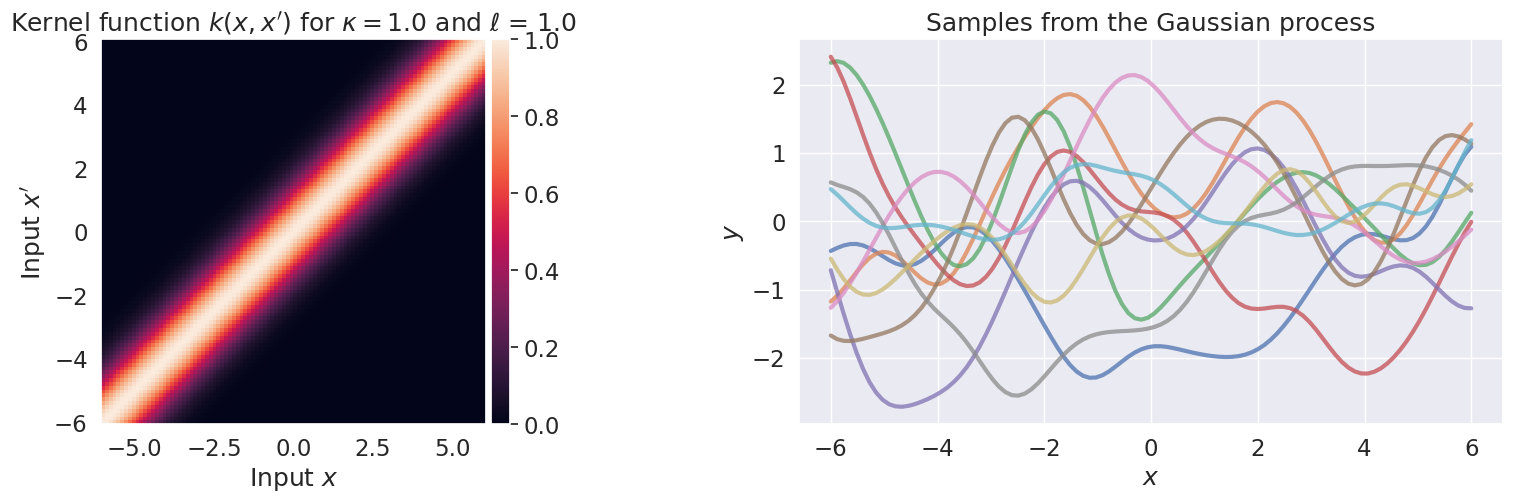

In [7]:
squared_exponential = lambda tau_squared, kappa, scale: kappa**2*np.exp(-0.5*tau_squared/scale**2)

def se_kernel(X1, X2, theta, jitter=1e-8):
    """ returns the NxM kernel matrix between the two sets of input X1 and X2 
    
    arguments:
    X1     -- NxD matrix
    X2     -- MxD matrix
    theta  -- vector with 2 elements: [kappa, scale]
    jitter -- scalar
    
    returns NxM matrix    
    """
    # extract hyperparameters
    kappa, scale = theta[0], theta[1]

    # compute all the pairwise squared distances efficiently
    dists_squared = np.sum((np.expand_dims(X1, 1) - np.expand_dims(X2, 0))**2, axis=-1)
    
    # squared exponential covariance function
    K = squared_exponential(dists_squared, kappa, scale)
    
    # add jitter to diagonal for numerical stability
    if len(X1) == len(X2) and np.allclose(X1, X2):
        K = K + jitter*np.identity(len(X1))
    
    return K

# create an Nx1 vector of equidistant points in [-6, 6]
N = 100
Xp = np.linspace(-6, 6, N)[:, None]

# hyperparameters
kappa = 1.
scale = 1.

num_samples = 10

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
Kpp = se_kernel(Xp, Xp, theta=[kappa, scale])
im = ax[0].pcolormesh(Xp.flatten(), Xp.flatten(), Kpp, shading='auto')
ax[0].set(xlabel='Input $x$', ylabel="Input $x'$", title=f"Kernel function $k(x, x')$ for $\kappa = {kappa:2.1f}$ and $\ell$ = {scale:2.1f}")
ax[0].grid(False)
ax[0].set_aspect('equal')
add_colorbar(im, fig, ax[0])

y_samples = generate_samples(0, Kpp, M=num_samples)
ax[1].plot(Xp, y_samples, alpha=0.75, linewidth=3);
ax[1].grid(True)
ax[1].set(xlabel='$x$', ylabel='$y$', title='Samples from the Gaussian process');


**Questions**

1.1) Look at the left figure above and give an interpretation of the structure of kernel matrix.
Hint: Compare the kernel values for pairs of points close to each other to pairs of points further apart
* The bottom left to upper right diagonal contains the variances i.e. $||x_m - x_m||_2^2$. and when we move off the diagonal we go to covariances between different xs that are further and further away from the x in the diagonal.

1.2) Change the parameters $\kappa, \ell$ and explain how they affect the structure of the kernel (left panel)
* From changing the parameters it looks like $\kappa$ controls the variance of the kernel. The larger the value the higher the variance
* It looks like $\ell$ controls size of the "covariance window" in the kernel. When $\ell$ is increased then values further and further apart will covariate stronger and stronger. If for example we were to set $\ell$ to a very high value then the kernel gives full covariance to most of the samples.

1.3) Change the parameters $\kappa, \ell$ and explain how they affect the prior samples (right panel)
* $\kappa$ controls the variance, so higher value gives higher variance in the prior samples and the opposite for low values of $\kappa$
* The value of $\ell$ determines how high the covariance between different xs is. So if we set $\ell$ to be very small then the xs do not covary with other xs, so their samples are only based on each x variance. If we make it very large then all values are highly covarying and so we end up with a flat prior, because even values on the one end of the prior have to vary with values on the other end of the prior.
    - This also means that we can actually smoothen our kernel by the choice of $\ell$ (higher $\ell$ to a certain degree if we don't want it flat)



The squared exponential kernel is an example of a **stationary** kernel, which means that the covariance function only depends on the difference between two points. Let $x_i$ and $x_j$ be two points in the input space and define $\tau = x_i - x_j$, then we can write

\begin{align*}
    k(x_i, x_j) = k(\tau) =  \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right), \tag{5}
\end{align*}


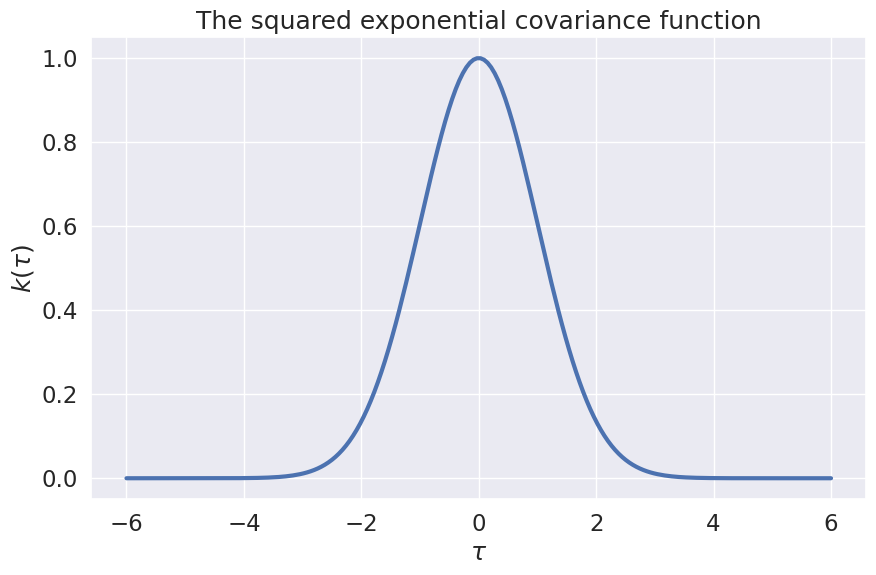

In [8]:
tau = np.linspace(-6, 6, 200)

kappa = 1
scale = 1

plt.figure(figsize=(10, 6))
plt.plot(tau, squared_exponential(tau**2, kappa=kappa, scale=scale), linewidth=3)
plt.title('The squared exponential covariance function')
plt.xlabel('$\\tau$')
plt.ylabel('$k(\\tau)$');


**Questions**

Suppose the distance between two input points $x_i$ and $x_j$ is $\|\tau\| = \|x_i - x_j\| = d\cdot\ell$.

1.4) What is the covariance between the function values $y(x_i)$ and $y(x_j)$ for $d = 0, 1, 2, 3, 4, 5$ for $\kappa = 1$?

Hint: Use eq. (5)

For $\kappa = 1$ and $\|\tau\| = d\cdot\ell$, we have 

$$\begin{align*}
k(x_i, x_j) = k(\tau) &= \kappa^2 \exp\left(-\frac{\|\tau\|^2_ 2}{2\ell^2}\right)\\
&= \exp\left(-\frac{\|d\ell\|^2_ 2}{2\ell^2}\right)\\
&= \exp\left(-\frac{d^2\ell^2}{2\ell^2}\right)\\
&= \exp\left(-\frac{d^2}{2}\right)\\
\end{align*}$$

For $d = 0, \ldots, 5$, this becomes:



In [9]:
d = range(5)

for d in np.arange(6):
    print('d = %d: %4.3f' % (d, np.exp(-d**2/2)))

d = 0: 1.000
d = 1: 0.607
d = 2: 0.135
d = 3: 0.011
d = 4: 0.000
d = 5: 0.000


### Part 2: Non-linear regression using Gaussian processes

In this part, we will study how Gaussian processes can be used for non-linear regression. Assume we have a regression dataset $\mathcal{D} = \left\lbrace \mathbf{x}_i, t_i \right\rbrace_{i=1}^N$. We will adopt the following model

$$
\begin{align*}
t_n = y(\mathbf{x}_n) + e_n,
\end{align*}
$$

where $y(\mathbf{x})$ is assumed to be a Gaussian process. Assuming the noise $e_n$ is i.i.d. and Gaussian, the joint model for the training data becomes:

\begin{align*}
p(\mathbf{t}, \mathbf{y}) = \mathcal{N}\left(\mathbf{t}|\mathbf{y}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{y} | \mathbf{0}, \mathbf{K}\right)
\end{align*}

where $(\mathbf{K})_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$ is the covariance matrix. 
We will also use the squared exponential covariance function in this part. Thus, this model (when using  the squared exponential covariance function) has three hyperparameters in total: $\mathbf{\theta} = \left\lbrace \sigma, \kappa, \ell\right\rbrace$.

We will use $\mathbf{\theta}_K = \left\lbrace \kappa, \ell\ \right\rbrace$ to denote the hyperparameters of the kernel $K$ and $\mathbf{\theta}$ to denote all hyperparameters of the model.

Our goal is to compute the distributions $p(y^*|\mathbf{t})$ and $p(t^*|\mathbf{t})$ for some new input point $\mathbf{x}^*$.









Below you are given a template for a function called **posterior**, which computes the posterior distribution of the function values $y(\mathbf{X}_p)$ for inputs $\mathbf{X}_p$ conditioned on the traning data $\mathcal{t}$.

In [10]:
def posterior(Xp, X, t, kernel_function, theta):
    """ returns the posterior distribution of y evaluated at each of the points in Xp conditioned on (X, t)
    
    Arguments:
    Xp               -- PxD prediction points
    X                -- NxD input points
    t                -- Nx1 observed values 
    kernel_function  -- kernel function of the form k(X1, X2, theta)
    theta            -- vector of hyperparameters
    
    returns:
    mu               -- Px1 mean vector
    Sigma            -- PxP covariance matrix
    """

    # extract hyperparameters
    sigma = theta[0]
    theta_K = theta[1:]
    
    # prepare relevant matrices
    k = kernel_function(Xp, X, theta=theta_K)
    K = kernel_function(X, X, theta=theta_K)
    Kp = kernel_function(Xp, Xp, theta=theta_K) 
    
    # Insert your solution for task 2.1 below
    C = K + sigma**2*np.identity(len(X)) 
    mu = np.dot(k, np.linalg.solve(C, t))
    Sigma = Kp - np.dot(k, np.linalg.solve(C, k.T))
    
    return mu, Sigma


# sanity check that your implementation returns the correct shapes
Xp = np.linspace(-3, 9, 100)[:, None]
mu_check, Sigma_check = posterior(Xp, np.zeros((0, 1)), np.zeros((0, 1)), se_kernel, [0.5, 1, 1])
assert mu_check.shape == (100, 1), "The dimensions of the posterior mu are wrong, check implementation"
assert Sigma_check.shape == (100, 100), "The dimensions of the posterior Sigma are wrong, check implementation"


**Question** 

2.1) Complete the implementation of the function **posterior** above.

Hints:
- Look at eq. (6.62), (6.66) and (6.67) in Bishop
- The function above computes the posterior $p(y^*|t, x^*)$ and not $p(t^*|t, x^*)$. Therefore, the noise variance $\sigma^2 = \beta^{-1}$ should not be included in $c$ as done in eq. (6.67)
- For inverting matrices, `np.linalg.solve` is numerically much more stable than `np.linalg.inv`.

Below you are given a simple toy data set $\mathcal{D} = \left\lbrace x_n, y_n \right\rbrace_{n=1}^N$ for $N = 50$ and we'll now fit a Gaussian process regression model to it.


In [11]:
# load data
data = np.load('./data_exercise4.npz')
N = data['N']
Xtrain = data['X']
ttrain = data['y']

Xp = np.linspace(-3, 9, 100)[:, None]

# function for plotting
def plot_data(ax):
    ax.plot(Xtrain, ttrain, 'k.', markersize=12, label='Data')
    ax.grid(True)
    ax.set_xlabel('Input $x$')
    ax.set_ylabel('Response $t$')
    ax.legend()

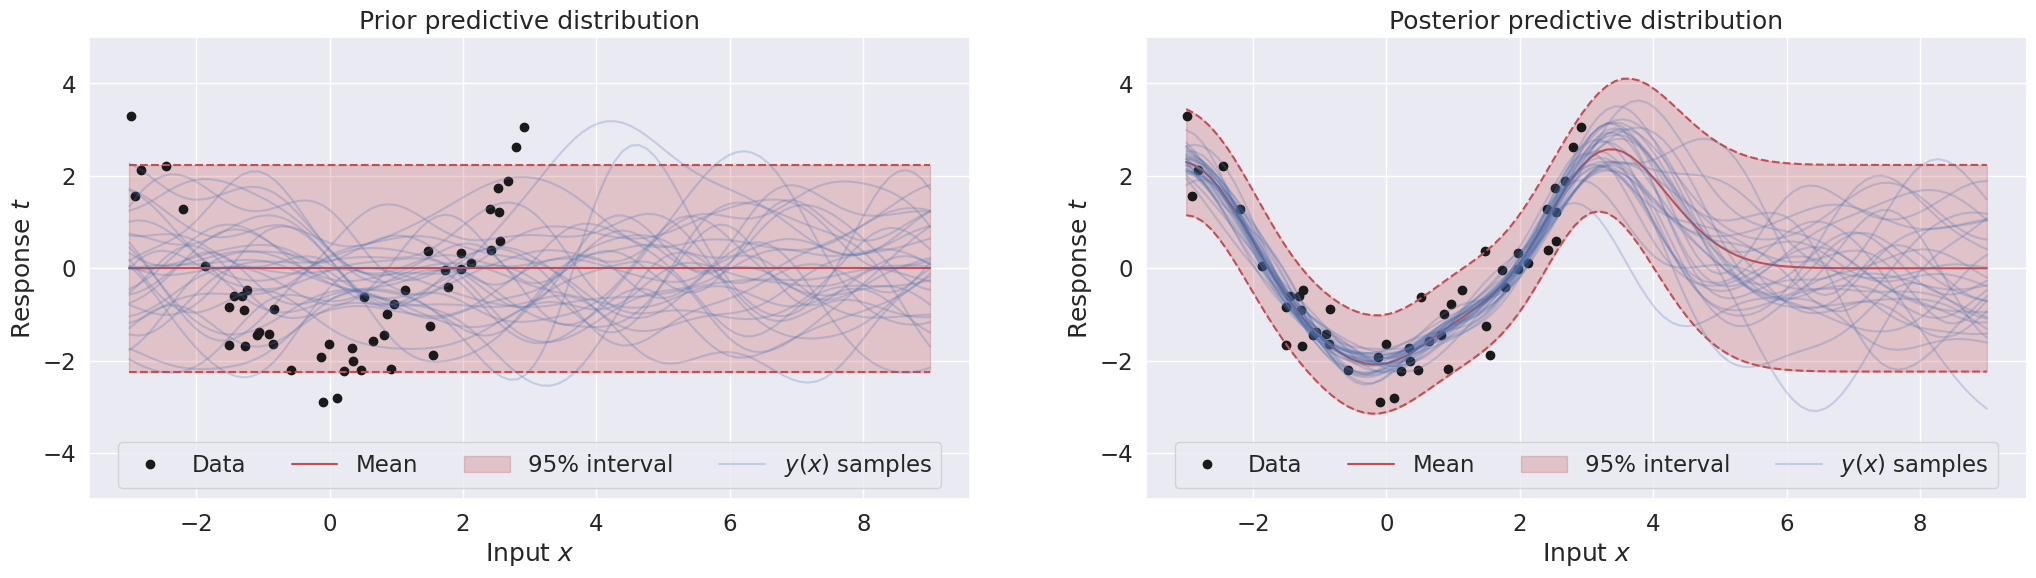

In [31]:
# hyperparameters
kappa = 1
scale = 1
sigma = .5
theta = [sigma, kappa, scale]

# prior mean and covariance
mu_prior, Sigma_prior = posterior(Xp, np.zeros((0, 1)), np.zeros((0, 1)), se_kernel, theta)

# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, Xtrain, ttrain, se_kernel, theta)
    
# plot
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xp, mu_prior, Sigma_prior, sigma, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=4)
ax[0].set_ylim((-5, 5))
plot_data(ax[1])
plot_with_uncertainty(ax[1], Xp, mu_post, Sigma_post, sigma, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=4)
ax[1].set_ylim((-5, 5));

The left figure above shows 30 samples from the prior distribution along with the mean and 95% interval from the prior predictive distribution, whereas the right figure shows the same quantities for the posterior distribution.


**Questions**


2.2) How does the prior and posterior differ in: a) regions close to the data points? b) in regions far from the data point? 
a) In regions close to the data points the posterior i fitted to the data points
b) In regions away from the data points the posterior is still very uncertain about the data, and therefore the prior influences the posterior more.


2.3) Can you explain this behaviour using the equations for the posterior mean and covariance (and what you saw in part 1)?
* The prior does not take the training data into account whereas the posterior get the train X and y target data and uses the covariance in the training X to compute C which is used for computing the mean and covariance. Therefore the posterior fits according to the training data whereas the prior does not take the data into consideration, but instead works on the zero vector.


2.4) Visualize the prior covariance matrix (`Sigma_prior`) and posterior covariance matrix (`Sigma_post`) side-by-side as images and comment on what you see
* The prior has highovariance for all x-values where the posterior has low variance for some of them and high for other. This is because the posterior has taken information into account when fitting to the training data, which has made its variance lower around the data points because the uncertainty has been reduced.


2.5) Change the values of kappa and scale and explain how it affects the prior and posterior. For example, what happens if you choose the lengthscale $\ell$ to be either 0.25, 1, or 5 while keeping $\kappa = 1$ and $\sigma = \frac12$? Do similar experiments with $\sigma$ and $\kappa$.
* Decreasing $\ell$ will make the function approximations less smooth. Increasing them will make them more smooth
* Decreasing $\kappa$ will decrease the variance increasing it will increase the variance. The posterior is however only really affected by this for the areas of the function where no training data i available. As it will fit to the areas where there is training data the variance will still be less here according to the training data.
* $\sigma$ controls the expected noise in the data (variance in the data) so increasing it means higher uncertainty in the function values and therfore a wider 95\% interval. If we decrease it the opposite happens and we get a narrow 95\% interval.






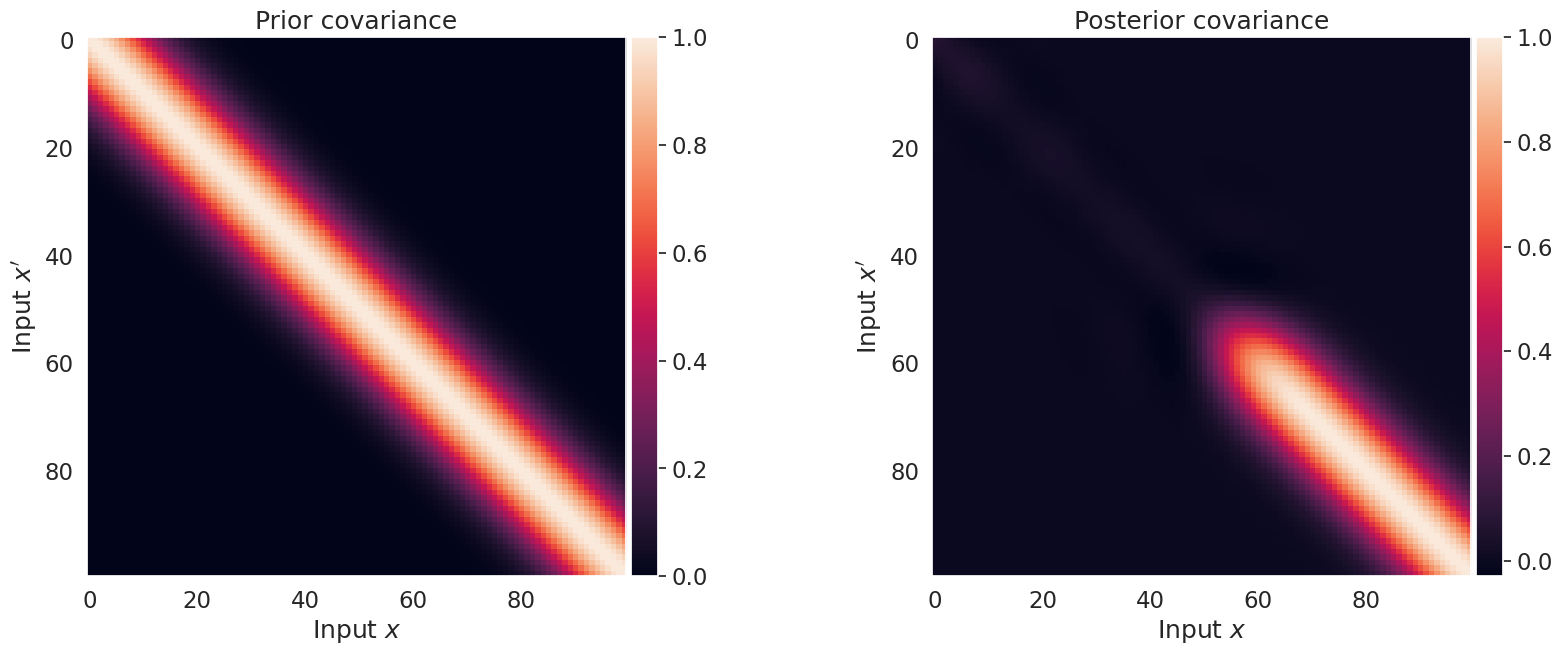

In [18]:
# 2.4
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
im = ax[0].imshow(Sigma_prior)
ax[0].grid(False)
ax[0].set(xlabel='Input $x$', ylabel="Input $x'$", title='Prior covariance')
add_colorbar(im, fig, ax[0])

im = ax[1].imshow(Sigma_post)
ax[1].grid(False)
ax[1].set(xlabel='Input $x$', ylabel="Input $x'$", title='Posterior covariance');
add_colorbar(im, fig, ax[1])

### Part 3: Hyperparameter optimization using the marginal likelihood

Now, we will see how we can use the ***marginal likelihood*** to estimate the hyperparameters of the model. If we let $\mathbf{\theta} \in \mathbb{R}^K$ denote all of our hyperparameters, then the **evidence approximation** suggests that we can estimate $\mathbf{\theta}$ as follows

\begin{align*}
\hat{\mathbf{\theta}} = \arg\max\limits_{\mathbf{\theta}} \ln p(\mathbf{t}|\mathbf{\theta}),
\end{align*}

where $p(\mathbf{t}|\mathbf{\theta})$ is the marginal likelihood of the model (see eq. (6.69) in Bishop).

The cell below provides an implementation of the log marginal likelihood and a function to optimize using gradient-based optimization.

In [32]:
def log_marginal_likelihood(X, t, kernel_function, theta):

    N = len(t)

    # extract hyperparameters
    sigma = theta[0]
    theta_K = theta[1:]
    
    # prepare kernels
    K = kernel_function(X, X, theta_K)
    C = K + sigma**2*np.identity(N)

    # compute Cholesky decomposition - this will be covered in week 5.
    L = np.linalg.cholesky(C)
    v = np.linalg.solve(L, t)

    # compute log marginal likelihood
    logdet_term = np.sum(np.log(np.diag(L)))
    quad_term =  0.5*np.sum(v**2)
    const_term = -0.5*N*np.log(2*np.pi)
    return const_term - logdet_term - quad_term

def optimize_hyperparameters(X, t, kernel_function, theta_init):

    # define optimization objective as the negative log marginal likelihood
    objective = lambda th: -log_marginal_likelihood(X, t, kernel_function, th)

    # optimize using gradients
    res = minimize(value_and_grad(objective), theta_init, jac=True)

    # check for success
    if not res.success:
        print('Warning: optimization failed!')

    # return resultss
    theta = res.x
    return theta


Let's run it on our toy dataset:

In [33]:
# optimize
theta_hat = optimize_hyperparameters(Xtrain, ttrain, se_kernel, theta_init=[1,1,1])

# extract individual hyperparameters
sigma_hat, kappa_hat, scale_hat = theta_hat

# print
print('Estimated hyperparameters')
print(f'\tsigma: {sigma_hat:3.2f}')
print(f'\tkappa: {kappa_hat:3.2f}')
print(f'\tscale: {scale_hat:3.2f}')


Estimated hyperparameters
	sigma: 0.59
	kappa: 2.92
	scale: 1.82


(-9.0, 9.0)

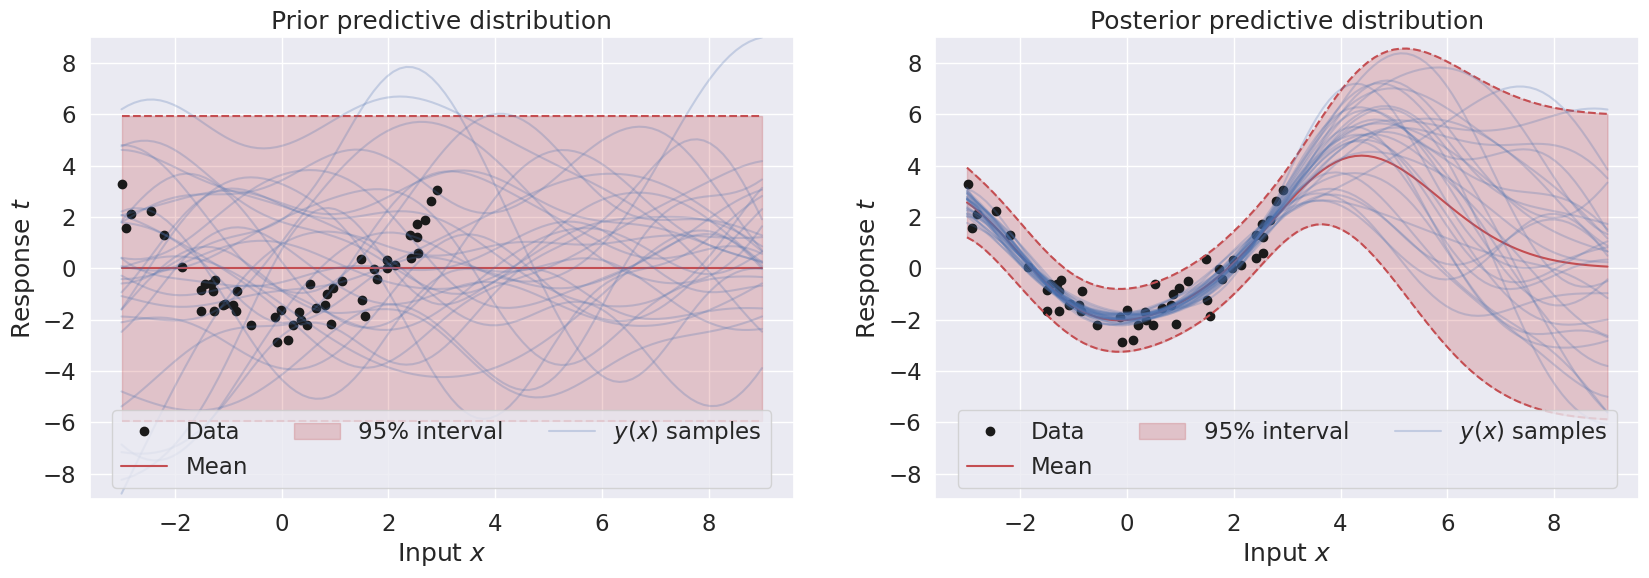

In [34]:
# prior mean and covariance
mu_prior, Sigma_prior = posterior(Xp, np.zeros((0, 1)), np.zeros((0, 1)), se_kernel, theta_hat)

# posterior mean and covariance
mu_post, Sigma_post = posterior(Xp, Xtrain, ttrain, se_kernel, theta_hat)
    
# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(ax[0])
plot_with_uncertainty(ax[0], Xp, mu_prior, Sigma_prior, sigma_hat, title='Prior predictive distribution', num_samples=30)
ax[0].legend(loc='lower center', ncol=3)
ax[0].set_ylim((-9, 9))
plot_data(ax[1])
plot_with_uncertainty(ax[1], Xp, mu_post, Sigma_post, sigma_hat, title='Posterior predictive distribution', num_samples=30)
ax[1].legend(loc='lower center', ncol=3)
ax[1].set_ylim((-9, 9))

***Questions***

3.1) Comment on the quality of the fit. Does it seem reasonable?
* The posterior predictive distribution fits well to the data and the uncertainty in the model for the unknown areas of the function seem fair enough.

3.2) If we were to fit the three hyperparameters using 5-fold cross-validation and a grid search rather than using the marginal likelihood, how many times would we have to train the model? Assume we would 10 different values for each hyperparameter.
* For each fold, we would have to compute $10^3 = 1000$ different parameter combinations and thus, we would have to train the model $5\cdot 1000 = 5000$ times in total.


### Part 4: Analysing the bike sharing data set

In this section, your task is to fit a GP regression model (with squared exponential kernel) to a subset of the bike sharing dataset (Source: [https://ride.capitalbikeshare.com/system-data](https://ride.capitalbikeshare.com/system-data)). The dataset consists of the number of rented bikes in 2011.

In [ ]:
data = np.load('./data_exercise4b.npz')
day = data['day']
bike_count = data['bike_count']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(day, bike_count, 'k.', label='Data')
ax.legend()
ax.set(xlabel='Days since 1/1-2011', ylabel='Bike count');


**Questions**

4.1) Log-transform the bike counts, remove the mean and scale to unit variance. Plot the preprocessed data set.

4.2) Estimate the hyperparameters of a Gaussian process regression model with a squared exponential kernel from the preprocessed data (the optimization process might take a couple minutes to run). Report the estimates values of each hyperparameter.

4.3) Compute and visualize the predictive distribution for the interval $\text{day} \in \left\lbrace 0, 1, 2, \dots, 370 \right\rbrace$.

4.4) The observation model $p(t|y) = \mathcal{N}(t(x)|y(x), \sigma^2)$ assumes the additive noise is **isotropic** and **identically distributed** for all observations. Is that a reasonable assumption for this data set?

4.5) **Optional** Generate 50 samples from the posterior in the interval [0, 370], map them back to the original measurement space and plot them on top of the original dataset